In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\insbattula\\Desktop\\ML-AAI_IPYNB_Files\\Datasets\\amazon-fine-food-reviews\\database.sqlite')
#con = sqlite3.connect('database.sqlite') 

filtered_data_full = pd.read_sql_query("""SELECT * FROM Reviews """, con)

print("Before removing 3 rated reviews ", filtered_data_full.shape)
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

filtered_data

Before removing 3 rated reviews  (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#Data Cleaning: Deduplication
#It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary 
#to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
print("filtered data size after removing the Rating 3 ----",filtered_data['Id'].size)

print("final data size after deleting duplicates ---- ",final['Id'].size)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

filtered data size after removing the Rating 3 ---- 525814
final data size after deleting duplicates ----  364173


69.25890143662969

In [10]:
#Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than 
#HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\insbattula\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
lemmatizer = WordNetLemmatizer()


def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))
# Lemmatize Single Word
print(lemmatizer.lemmatize("tasty"))


{'this', 'other', 'yourself', 'had', "shouldn't", 'so', 'from', 'o', "it's", 'being', 'or', 'why', 'any', 'but', 'too', 'an', 'don', 'she', 'at', 'then', 'should', 'its', 'further', 'no', 'shouldn', 'hers', 'both', 'can', 'have', 'will', 'here', 'which', 'and', 'off', 'mightn', 'are', 'herself', 'i', 'these', 'own', 's', 'isn', 'yourselves', 'yours', 'just', 'we', 'before', 'doesn', 'hasn', 'ma', 'if', 'his', 'while', 'the', 'me', 'my', 'what', 'those', 'having', 'up', 'after', 'is', 'doing', 'wouldn', 'weren', 'some', "you'd", 'until', "aren't", 'does', 'out', 'hadn', "hasn't", 'them', 'needn', "weren't", 'on', 'they', 'how', 't', "couldn't", "needn't", "you'll", 'ain', 'over', 'didn', 'be', 'mustn', 'ours', "mustn't", 'same', 'for', 'a', 'itself', 'ourselves', 'am', 'in', 'you', "she's", "wouldn't", 'once', 've', 'been', 'were', 'has', 'their', "shan't", 'such', 'her', 'it', "isn't", "wasn't", 'than', 'each', 'down', 'where', 'do', 'himself', 'because', 'him', 'that', 'your', 're', '

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews 
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [18]:
final.head() #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [19]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [20]:
# To get 2k +ve and 2k -ve reviews randomly. 
# I have reduced the no of reviews to 200 as sysytem not responding for more than 1000

data_pos = final[final["Score"] == "positive"].sample(n = 200)
data_neg = final[final["Score"] == "negative"].sample(n = 200)
final_4000 = pd.concat([data_pos, data_neg])
final_4000.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
178029,193048,B00023323W,A26X56TW77KQR6,Scott Law,10,10,positive,1138147200,Don't be fooled - this sauce rules!,I just got back from a trip to St. Maarten and...,b'got back trip maarten tabl restaur bottl sau...
513189,554867,B000TYF4DA,AONPBVP3HC4TU,Rocko,2,2,positive,1306800000,Kellogg's variety pack,Yes you can buy something similar at the groce...,b'yes buy someth similar groceri store nice bu...
335297,362798,B000LQNK6E,A3A6RQ2P4X9VVN,Rosendo,0,0,positive,1344816000,Best Ramen Ever!!!,"If you're looking for outstanding taste, consi...",b'your look outstand tast consist conveni pack...
4697,5099,B004157PZI,A2IUXT71YHHULC,"Junaid A. Bholat ""J Bholat""",3,3,positive,1329350400,best and truthfull company,this is the best halal beef jerky i have ever ...,b'best halal beef jerki ever tast also compani...
35098,38171,B0027UQYZQ,A14XRI4U6BRG8T,Dw,1,1,positive,1310774400,Worth the expensive price,I bought this product because I needed freezer...,b'bought product need freezer tray tri use rem...


In [21]:
score_4000 = final_4000["Score"]
score_4000.shape

(400,)

In [22]:
final_4000['CleanedText'].values

array([b'got back trip maarten tabl restaur bottl sauc love first tast put tuna filet total hot sauc heaven brought bottl back sure surviv month order much incred sauc',
       b'yes buy someth similar groceri store nice buy amazon ship state arriv destin arizona undamag everyon love someth box none cereal stale great concern mine',
       b'your look outstand tast consist conveni packag one order ramen one best tast ramen noddl let add pretti spici like your spici food wont like',
       b'best halal beef jerki ever tast also compani truli give orthodox muslim good choic buy call ask slaughter process quick give answer unlik muslim compani tri deceiv consum',
       b'bought product need freezer tray tri use remaind gift card glad gift card toward product know expens reason enjoy use often everi day think like feel like realli get money worth silicon make easi clean durabl breez pop food without worri break devic like lid part realli feel like best could make lid fit proper snugg size

In [23]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [24]:
final_counts

<400x2901 sparse matrix of type '<class 'numpy.int64'>'
	with 12698 stored elements in Compressed Sparse Row format>

In [25]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [26]:
final_counts.get_shape()

(400, 2901)

# Bi-Grams and n-Grams.
Motivation

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [27]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


# Observation:- 
From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [28]:
#bi-gram, tri-gram and n-gram 
# In the below example we could see that we are building Bi-grams to avoid like & not like cases.

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [29]:
final_bigram_counts.get_shape()

(400, 16192)

In [30]:
 from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

(400, 16192)

In [31]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [32]:
# convert sparse to dense as tsne takes dense vector
std_data = std_data.todense()

In [33]:
type(std_data)

numpy.matrix

C:\Users\insbattula\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


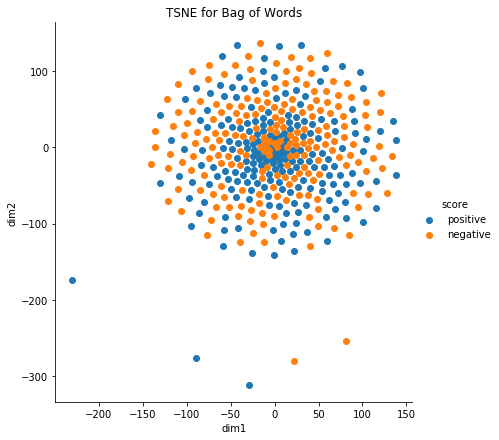

In [34]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

Observation:- Here, we are unable to simply draw a hyperplane and separate +ve and -ve reviews because it overlap each other. But we will have some alternative way to separates review.

# TF-IDF

In [35]:
#Sample example
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
        ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)
X

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [36]:
if_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf= if_idf_vect.fit_transform(final_4000['CleanedText'].values)

In [37]:
print(final_4000['CleanedText'].values)
final_tf_idf

[b'got back trip maarten tabl restaur bottl sauc love first tast put tuna filet total hot sauc heaven brought bottl back sure surviv month order much incred sauc'
 b'yes buy someth similar groceri store nice buy amazon ship state arriv destin arizona undamag everyon love someth box none cereal stale great concern mine'
 b'your look outstand tast consist conveni packag one order ramen one best tast ramen noddl let add pretti spici like your spici food wont like'
 b'best halal beef jerki ever tast also compani truli give orthodox muslim good choic buy call ask slaughter process quick give answer unlik muslim compani tri deceiv consum'
 b'bought product need freezer tray tri use remaind gift card glad gift card toward product know expens reason enjoy use often everi day think like feel like realli get money worth silicon make easi clean durabl breez pop food without worri break devic like lid part realli feel like best could make lid fit proper snugg size cube perfect need good help size 

<400x16192 sparse matrix of type '<class 'numpy.float64'>'
	with 27366 stored elements in Compressed Sparse Row format>

In [38]:
final_tf_idf[300:390:2].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler(with_mean = False)
std_data  = std.fit_transform(final_tf_idf)


In [40]:
score_4000.shape

(400,)

In [41]:
std_data  = std_data.todense()

In [42]:
sparsity = 1.0 - count_nonzero(std_data) / std_data.size
print(sparsity)

NameError: name 'count_nonzero' is not defined

C:\Users\insbattula\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


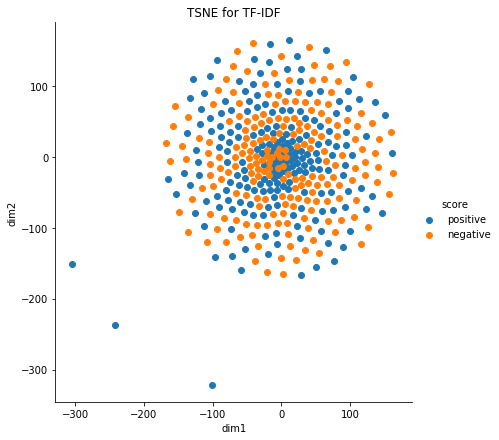

array([[-77.8401107788086, -60.56195068359375, 'positive'],
       [-88.26558685302734, 61.18525314331055, 'positive'],
       [-47.343040466308594, 78.85436248779297, 'positive'],
       ...,
       [-9.27470588684082, 74.93650817871094, 'negative'],
       [156.61378479003906, -52.42097473144531, 'negative'],
       [106.9117202758789, -15.8346586227417, 'negative']], dtype=object)

In [43]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50, learning_rate=200.0, n_iter=1000)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()
tsne_data

In [44]:

features = if_idf_vect.get_feature_names()
len(features)

16192

In [45]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[0. 0. 0. ... 0. 0. 0.]


# Word2Vec

In [48]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('D:\DataScienceMaterial\GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#model.wv['computer']

In [ ]:
#model.wv.similarity('woman', 'man')

In [ ]:
#model.wv.most_similar('woman')
#model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

#model.wv.most_similar('tasty') 
#model.wv.similarity('tasty', 'tast')

In [64]:
final_4000.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
178029,193048,B00023323W,A26X56TW77KQR6,Scott Law,10,10,positive,1138147200,Don't be fooled - this sauce rules!,I just got back from a trip to St. Maarten and...,b'got back trip maarten tabl restaur bottl sau...
513189,554867,B000TYF4DA,AONPBVP3HC4TU,Rocko,2,2,positive,1306800000,Kellogg's variety pack,Yes you can buy something similar at the groce...,b'yes buy someth similar groceri store nice bu...
335297,362798,B000LQNK6E,A3A6RQ2P4X9VVN,Rosendo,0,0,positive,1344816000,Best Ramen Ever!!!,"If you're looking for outstanding taste, consi...",b'your look outstand tast consist conveni pack...
4697,5099,B004157PZI,A2IUXT71YHHULC,"Junaid A. Bholat ""J Bholat""",3,3,positive,1329350400,best and truthfull company,this is the best halal beef jerky i have ever ...,b'best halal beef jerki ever tast also compani...
35098,38171,B0027UQYZQ,A14XRI4U6BRG8T,Dw,1,1,positive,1310774400,Worth the expensive price,I bought this product because I needed freezer...,b'bought product need freezer tray tri use rem...


In [56]:
from gensim import models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
import pickle

# Train your own Word2Vec model using your own text corpus
# created 
import gensim
list_of_sent = []
for sent in final_4000['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [58]:
print(final_4000['Text'].values[1])
print("*****************************************************************")
print(list_of_sent[1])

Yes you can buy something similar at the grocery store. It was nice to buy through Amazon and have it shipped out of state. It arrived at my destination in Arizona undamaged and everyone loved that there was something in the box for all. None of the cereal was stale, which was a great concern of mine.
*****************************************************************
['yes', 'you', 'can', 'buy', 'something', 'similar', 'at', 'the', 'grocery', 'store', 'it', 'was', 'nice', 'to', 'buy', 'through', 'amazon', 'and', 'have', 'it', 'shipped', 'out', 'of', 'state', 'it', 'arrived', 'at', 'my', 'destination', 'in', 'arizona', 'undamaged', 'and', 'everyone', 'loved', 'that', 'there', 'was', 'something', 'in', 'the', 'box', 'for', 'all', 'none', 'of', 'the', 'cereal', 'was', 'stale', 'which', 'was', 'a', 'great', 'concern', 'of', 'mine']


In [59]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [60]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\insbattula\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [61]:
w2v.shape

(805, 50)

In [62]:
words = list(w2v_model.wv.vocab)
print(len(words))

805


In [63]:
w2v_model.wv.most_similar('tasty') # since i have coosen only 400 words, its giving ir-relavent words

[('tried', 0.999664306640625),
 ('on', 0.9996118545532227),
 ('and', 0.9995754361152649),
 ('these', 0.999566376209259),
 ('also', 0.9995635747909546),
 ('would', 0.9995589256286621),
 ('was', 0.9995558261871338),
 ('only', 0.9995555877685547),
 ('product', 0.999548077583313),
 ('but', 0.9995454549789429)]

In [65]:
w2v_model.wv.most_similar('like')

[('an', 0.9998881816864014),
 ('was', 0.9998738765716553),
 ('i', 0.9998720288276672),
 ('but', 0.9998701810836792),
 ('after', 0.9998656511306763),
 ('so', 0.9998650550842285),
 ('it', 0.9998650550842285),
 ('or', 0.999861478805542),
 ('very', 0.9998571872711182),
 ('the', 0.9998551607131958)]

In [73]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW indexing & value
count_vect_feat.index('like')
print(count_vect_feat[7813])

like


# Avg W2V, TFIDF-W2V

In [74]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

400
50


C:\Users\insbattula\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


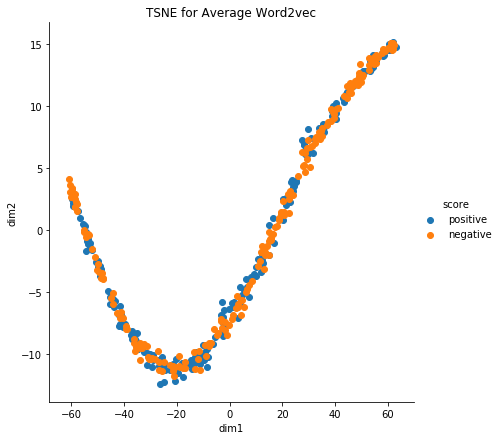

In [75]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

Observations:- Here, all +ve and -ve reviews are not well seperated this also looks like bow and tfidf vector representations.

In [76]:
# To avoid warnings 
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat = if_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [79]:
# To know length of tfidf vector
len(tfidf_sent_vectors)

400

In [80]:
np.isnan(tfidf_sent_vectors)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [81]:
# To replace nan with 0 and inf with large finite number

tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

C:\Users\insbattula\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


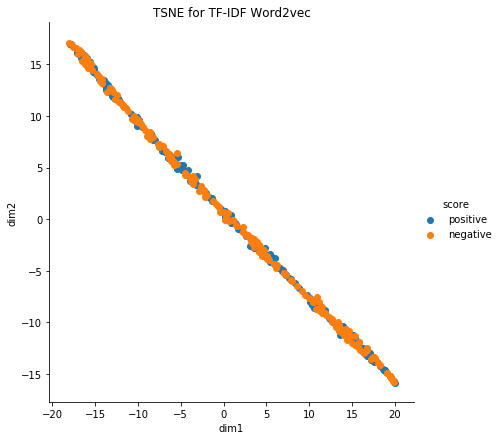

In [82]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

Observation- This plot also looks like the bow, tfidf and avg word2vec.Both +ve and -ve reviwes are not well seperated they overlapped each other.

Conclusions:-

AS none of TSNE representation gives a well separated both +ve and -ve reviews.
We can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.
We will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.